In [ ]:
import pandas as pd
import re

data = []
with open('./perf_experiments_clean.csv', 'r') as f:
    for line in f:
        # k=8, mu=500000000, d=1.0e-10, t=322.072625
        match = re.match(r'k=(\d+), mu=(\d+), d=([\d.e+-]+), t=([\d.]+)', line.strip())
        if match:
            k, mu, d, t = match.groups()
            data.append({
                'k': int(k),
                'mu': int(mu),
                'd': float(d),
                't': float(t)
            })

df = pd.DataFrame(data)
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nUnique values:")
print(f"k: {sorted(df['k'].unique())}")
print(f"mu: {sorted(df['mu'].unique())}")
print(f"d: {sorted(df['d'].unique())}")

   k         mu             d           t
0  8  500000000  1.000000e-10  322.072625
1  8  500000000  1.000000e-10   89.941038
2  8  500000000  1.000000e-10  115.496585
3  8  500000000  5.000000e-09   86.848877
4  8  500000000  5.000000e-09   41.345273

Dataset shape: (240, 4)

Unique values:
k: [np.int64(8), np.int64(16), np.int64(32), np.int64(64), np.int64(128)]
mu: [np.int64(500000000), np.int64(1500000000), np.int64(2147483648), np.int64(3000000000)]
d: [np.float64(1e-10), np.float64(5e-09), np.float64(1.5e-08), np.float64(5e-08)]


/tmp/ipykernel_49720/2509969643.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(data_for_boxplot, labels=k_values)


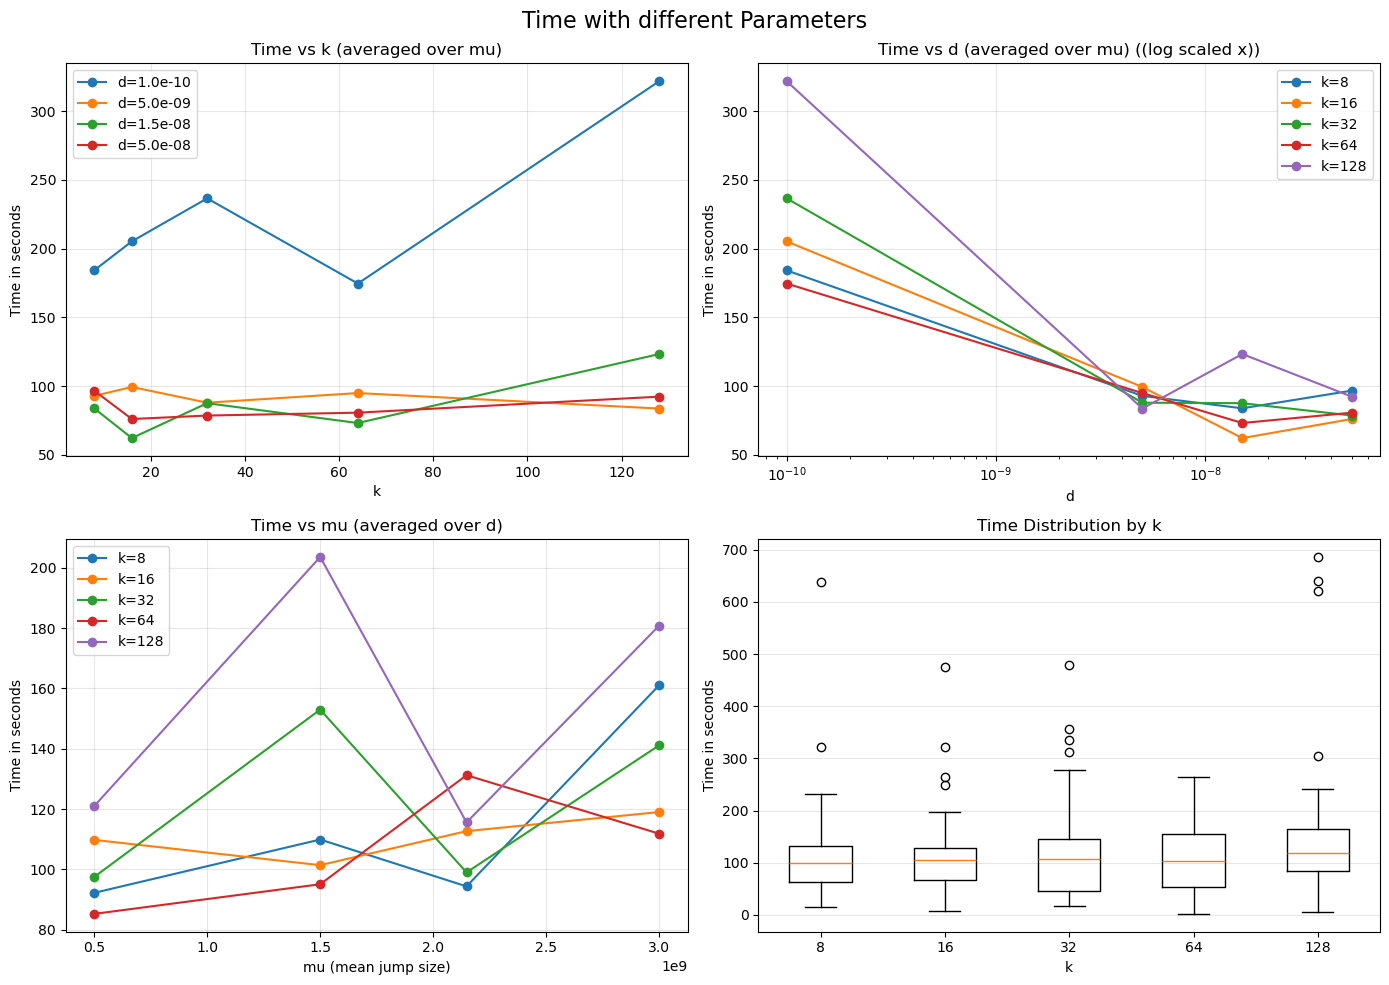

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Time with different Parameters', fontsize=16)

# Plot 1: Time vs k (for each d value)
ax1 = axes[0, 0]
for d_val in sorted(df['d'].unique()):
    subset = df[df['d'] == d_val].groupby('k')['t'].mean()
    ax1.plot(subset.index, subset.values, marker='o', label=f'd={d_val:.1e}')
ax1.set_xlabel('k')
ax1.set_ylabel('Time in seconds')
ax1.set_title('Time vs k (averaged over mu)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Time vs d (for each k value)
ax2 = axes[0, 1]
for k_val in sorted(df['k'].unique()):
    subset = df[df['k'] == k_val].groupby('d')['t'].mean()
    ax2.plot(subset.index, subset.values, marker='o', label=f'k={k_val}')
ax2.set_xlabel('d')
ax2.set_ylabel('Time in seconds')
ax2.set_title('Time vs d (averaged over mu) ((log scaled x))')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Time vs mu (for each k value)
ax3 = axes[1, 0]
for k_val in sorted(df['k'].unique()):
    subset = df[df['k'] == k_val].groupby('mu')['t'].mean()
    ax3.plot(subset.index, subset.values, marker='o', label=f'k={k_val}')
ax3.set_xlabel('mu (mean jump size)')
ax3.set_ylabel('Time in seconds')
ax3.set_title('Time vs mu (averaged over d)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Box plot showing variance for each k
ax4 = axes[1, 1]
k_values = sorted(df['k'].unique())
data_for_boxplot = [df[df['k'] == k]['t'].values for k in k_values]
ax4.boxplot(data_for_boxplot, labels=k_values)
ax4.set_xlabel('k')
ax4.set_ylabel('Time in seconds')
ax4.set_title('Time Distribution by k')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('performance_analysis.svg')
plt.show()

In [8]:
# Statistical summary
print("=== Performance Statistics ===\n")

print("Average time by k:")
print(df.groupby('k')['t'].agg(['mean', 'std', 'min', 'max']).round(2))

print("\n\nAverage time by d:")
print(df.groupby('d')['t'].agg(['mean', 'std', 'min', 'max']).round(2))

print("\n\nAverage time by mu:")
print(df.groupby('mu')['t'].agg(['mean', 'std', 'min', 'max']).round(2))

=== Performance Statistics ===

Average time by k:
       mean     std    min     max
k                                 
8    114.39   97.20  15.30  639.13
16   110.71   83.96   6.43  476.10
32   122.65   97.06  17.11  479.08
64   105.83   64.20   1.75  264.01
128  155.27  143.56   6.15  686.30


Average time by d:
                mean     std    min     max
d                                          
1.000000e-10  224.45  144.64  46.16  686.30
5.000000e-09   91.74   39.41  12.67  177.92
1.500000e-08   86.01   50.08  12.40  231.86
5.000000e-08   84.86   48.00   1.75  175.71


Average time by mu:
              mean     std    min     max
mu                                       
500000000   101.12   73.76  15.30  357.13
1500000000  132.59  119.78   1.75  640.08
2147483648  110.56   63.31  12.40  277.69
3000000000  142.80  129.18   6.43  686.30


In [11]:

# Stats for perf_normal_parms.csv if present
try:
    normal_times = []
    with open('./perf_normal_parms.csv', 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('t='):
                normal_times.append(float(line.split('=')[1]))
    if normal_times:
        import numpy as np
        arr = np.array(normal_times)
        stats = {
            'mean': arr.mean(),
            'std': arr.std(ddof=1),
            'min': arr.min(),
            'max': arr.max(),
            'n': arr.size,
        }
        print(f"\nperf_normal_parms.csv stats (n={stats['n']}):")
        print({k: round(v, 3) for k, v in stats.items() if k != 'n'}, "n=", stats['n'])
except FileNotFoundError:
    print("\nperf_normal_parms.csv not found; skipping its stats.")


perf_normal_parms.csv stats (n=20):
{'mean': np.float64(100.501), 'std': np.float64(58.081), 'min': np.float64(22.809), 'max': np.float64(232.016)} n= 20
